In [1]:
cd /home/nico/richai/

/home/nico/richai


In [2]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay
)
import pandas as pd
import matplotlib.pyplot as plt

# Plotting utils

In [3]:
target_names = ["muon", "pion"]

In [4]:
def plot_cm(y_true, y_pred, target_names, normalize="true"):
    fig, ax = plt.subplots(figsize=(10, 10))
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(ax=ax, cmap='cividis', values_format = '.4f')

    ax.set_ylabel('Actual class', fontsize=18)
    ax.set_xlabel('Predicted class', fontsize=18)
    plt.setp(ax.get_xticklabels(), fontsize=15)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.suptitle("Validation Set Confusion Matrix", y=.92, fontsize=20)
    
    for labels in disp.text_.ravel():
        labels.set_fontsize(15)

    plt.show()

In [5]:
def show_results(path):
    results = pd.read_csv(path)
    
    print(
        classification_report(
            y_true=results["labels"],
            y_pred=results["predictions"],
            target_names=target_names
        )
    )
    
    plot_cm(
        y_true=results["labels"],
        y_pred=results["predictions"],
        target_names=target_names
    )
        

# Model results

## Dynamic Graph CNN v1

- $\text{Epochs} = 4$
- $k = 8$
- $\delta = 0.15$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

              precision    recall  f1-score   support

        muon       0.78      0.61      0.69     43045
        pion       0.68      0.83      0.75     42779

    accuracy                           0.72     85824
   macro avg       0.73      0.72      0.72     85824
weighted avg       0.73      0.72      0.72     85824



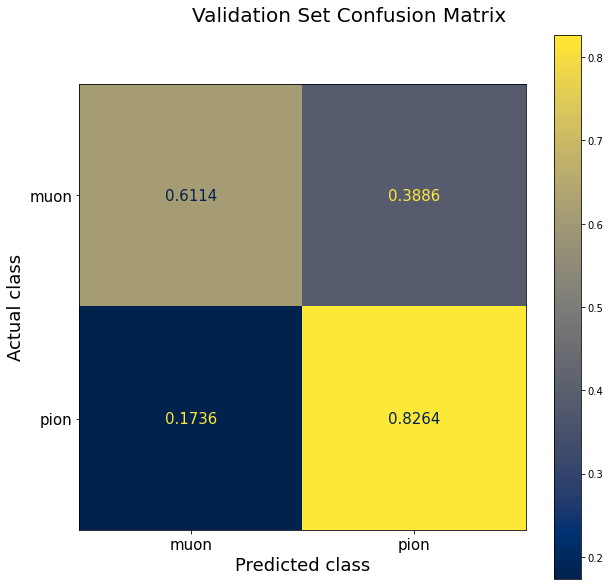

In [6]:
show_results("saved_models/dgcnn_k8_delta015_results.csv")

## Dynamic Graph CNN v2

- $\text{Epochs} = 4$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

              precision    recall  f1-score   support

        muon       0.83      0.69      0.75     43044
        pion       0.73      0.86      0.79     42780

    accuracy                           0.77     85824
   macro avg       0.78      0.77      0.77     85824
weighted avg       0.78      0.77      0.77     85824



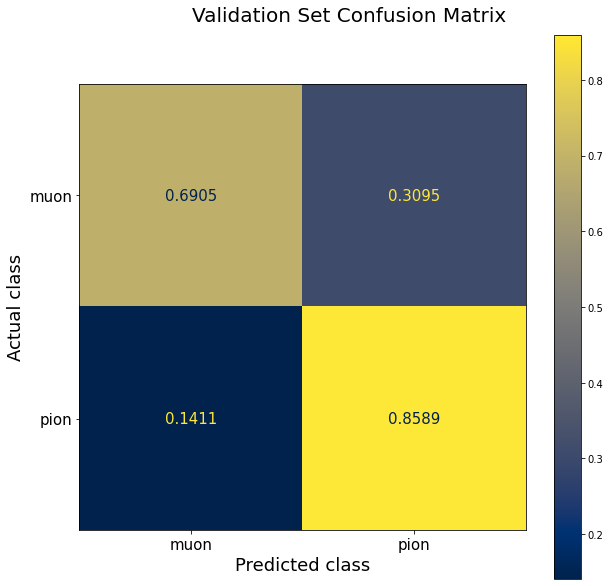

In [7]:
show_results("saved_models/dgcnn_k8_delta030_results.csv")

## Dynamic Graph CNN v3

- $\text{Epochs} = 4$
- $k = 16$
- $\delta = 0.15$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

              precision    recall  f1-score   support

        muon       0.76      0.65      0.70     43037
        pion       0.69      0.80      0.74     42787

    accuracy                           0.72     85824
   macro avg       0.73      0.72      0.72     85824
weighted avg       0.73      0.72      0.72     85824



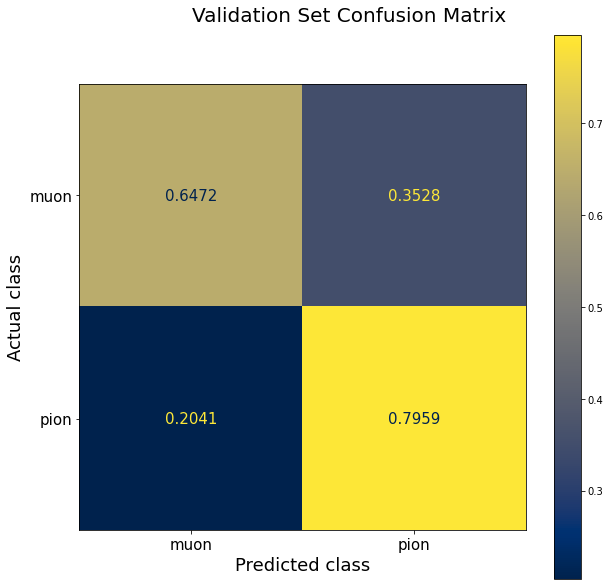

In [8]:
show_results("saved_models/dgcnn_k16_delta015_results.csv")

## Dynamic Graph CNN v4

- $\text{Epochs} = 4$
- $k = 16$
- $\delta = 0.30$
- $\text{Momentum} = \text{False}$
- $\text{Radius} = \text{False}$

              precision    recall  f1-score   support

        muon       0.86      0.61      0.71     43041
        pion       0.70      0.90      0.79     42783

    accuracy                           0.76     85824
   macro avg       0.78      0.76      0.75     85824
weighted avg       0.78      0.76      0.75     85824



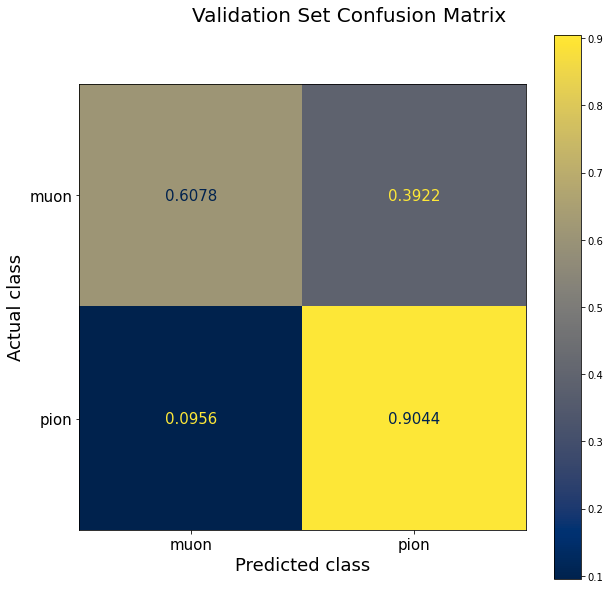

In [9]:
show_results("saved_models/dgcnn_k16_delta030_results.csv")

## Dynamic Graph CNN v5

- $\text{Epochs} = 4 \text{ and } 8$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{True}$
- $\text{Radius} = \text{False}$

#### After 4 epochs

              precision    recall  f1-score   support

        muon       0.91      0.80      0.85     43048
        pion       0.82      0.93      0.87     42776

    accuracy                           0.86     85824
   macro avg       0.87      0.86      0.86     85824
weighted avg       0.87      0.86      0.86     85824



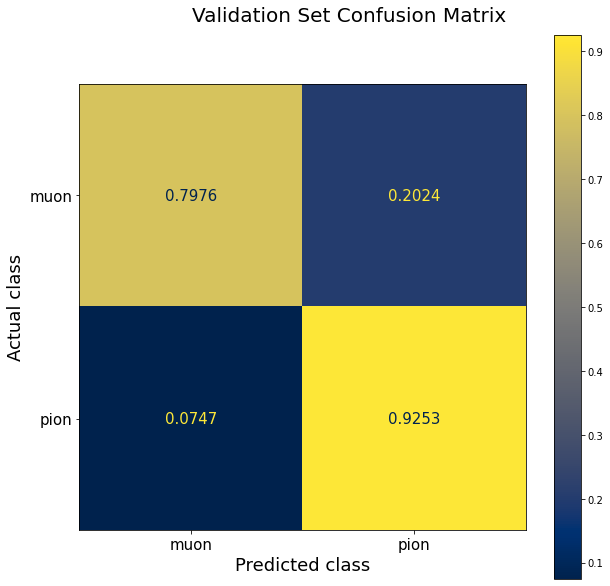

In [10]:
show_results("saved_models/dgcnn_k8_delta030_momentum_4epochs.csv")

#### After 8 epochs

              precision    recall  f1-score   support

        muon       0.97      0.32      0.49     43041
        pion       0.59      0.99      0.74     42783

    accuracy                           0.66     85824
   macro avg       0.78      0.66      0.61     85824
weighted avg       0.78      0.66      0.61     85824



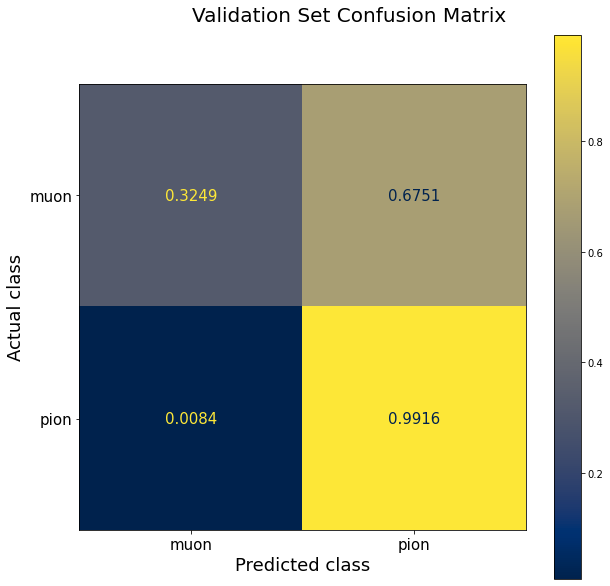

In [11]:
show_results("saved_models/dgcnn_k8_delta030_momentum_8epochs.csv")

## Dynamic Graph CNN v6

- $\text{Epochs} = 4$
- $k = 8$
- $\delta = 0.30$
- $\text{Momentum} = \text{True}$
- $\text{Radius} = \text{True}$

              precision    recall  f1-score   support

        muon       0.96      0.91      0.94     43044
        pion       0.92      0.96      0.94     42780

    accuracy                           0.94     85824
   macro avg       0.94      0.94      0.94     85824
weighted avg       0.94      0.94      0.94     85824



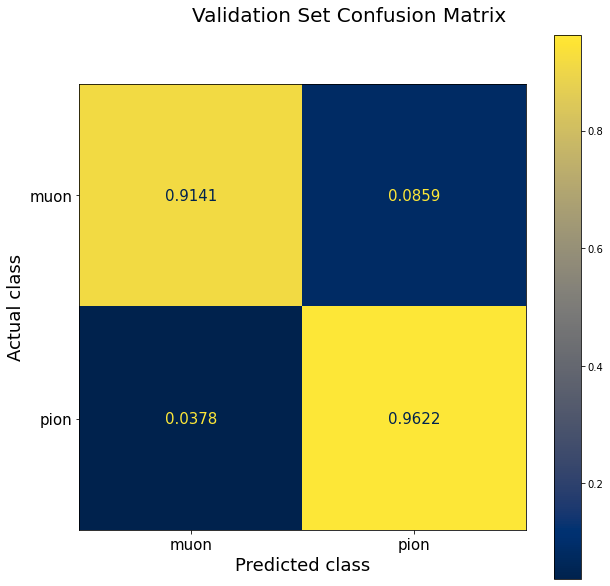

In [12]:
show_results("saved_models/dgcnn_k8_delta030_momentum_radius.csv")

## ROC Curves

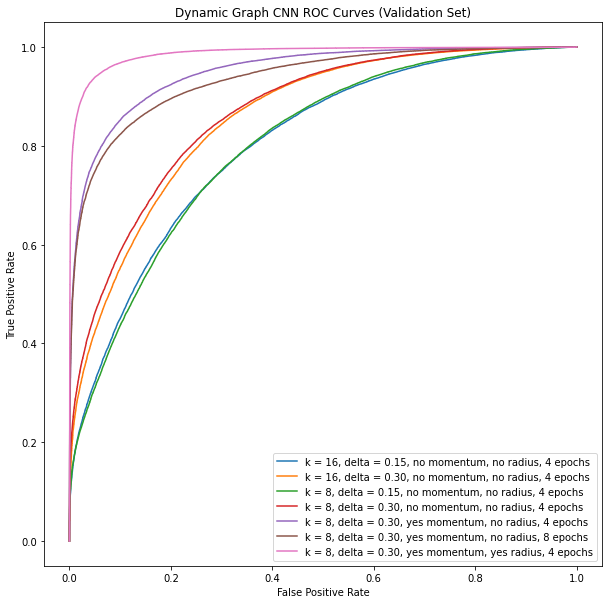

In [17]:
models = {
    "k = 16, delta = 0.15, no momentum, no radius, 4 epochs": "dgcnn_k16_delta015_results.csv",
    "k = 16, delta = 0.30, no momentum, no radius, 4 epochs": "dgcnn_k16_delta030_results.csv",
    "k = 8, delta = 0.15, no momentum, no radius, 4 epochs": "dgcnn_k8_delta015_results.csv",
    "k = 8, delta = 0.30, no momentum, no radius, 4 epochs": "dgcnn_k8_delta030_results.csv",
    "k = 8, delta = 0.30, yes momentum, no radius, 4 epochs": "dgcnn_k8_delta030_momentum_4epochs.csv",
    "k = 8, delta = 0.30, yes momentum, no radius, 8 epochs": "dgcnn_k8_delta030_momentum_8epochs.csv",
    "k = 8, delta = 0.30, yes momentum, yes radius, 4 epochs": "dgcnn_k8_delta030_momentum_radius.csv",
}

def plot_roc_curves(models):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for name, path in models.items():
        df = pd.read_csv(f"saved_models/{path}")

        fpr, tpr, _ = roc_curve(
            y_true=df["labels"],
            y_score=df["probabilities"],
        )

        disp = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=name)

        disp.plot(ax=ax)
    
    ax.set_title("Dynamic Graph CNN ROC Curves (Validation Set)")
    plt.show()
    

plot_roc_curves(models)